O. Pannekoucke$^{1,2,3}$

$^1$ INPT-ENM, Toulouse, France

$^2$ CNRM, Université de Toulouse, Météo-France, CNRS, Toulouse, France

$^3$ CERFACS, Toulouse, France

(olivier.pannekoucke@meteo.fr)

**Abstract**

This notebook illustrates the use of sympkf to build and handle the PKF dynamics associated with the advection in 2D 
$$
        \partial_t c +\mathbf{u}\nabla c = 0,
$$
where $c$ is a function $t,x,y$ and  $\mathbf{u}=(u(x,y), v(x,y))$ is the stationnary velocity field.

For this dynamics, the resulting PKF system is closed and reads as (in aspect tensor form) 
$$
        \left\{
        \begin{array}{l}
        \partial_t c +\mathbf{u}\nabla c = 0,\\
        \partial_t V_c +\mathbf{u}\nabla V_c = 0,\\
        \partial_t \mathbf{s}_c +\mathbf{u}\nabla\mathbf{s}_c = 
            \left(\nabla\mathbf{u}\right) \mathbf{s}_c+ \mathbf{s}_c\left(\nabla\mathbf{u}\right)^T.
        \end{array}
        \right .
$$

# Definition of the 2D advection equation

In [1]:
import sympy
sympy.init_printing() 

**Definition of the dynamics from sympy tools**

In [1]:
import sympy
from sympy import init_printing
init_printing() 

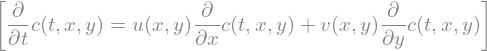

In [14]:
from sympy import Function, Derivative, Eq, symbols
t, x, y = symbols('t x y')
c = Function('c')(t,x,y)
u = Function('u')(x,y)
v = Function('v')(x,y)
dynamics = [
    Eq(Derivative(c,t), u*Derivative(c,x)+v*Derivative(c,y)),    
]
display(dynamics)

In [16]:
from sympkf import PDESystem
dynamics = PDESystem(dynamics)

# Computation of the PKF dynamics by using SymPKF

In [17]:
from sympkf.symbolic import SymbolicPKF
pkf_advection = SymbolicPKF(dynamics)

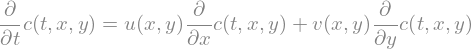

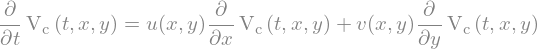

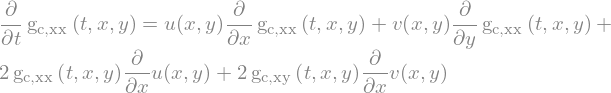

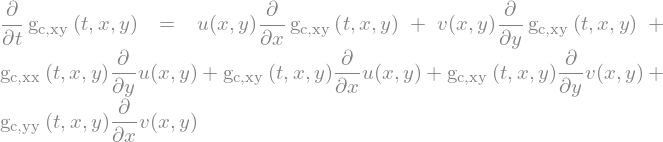

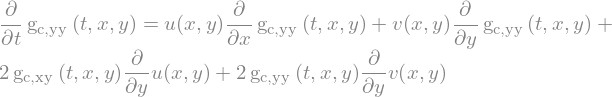

In [18]:
for equation in pkf_advection.in_metric:    display(equation)

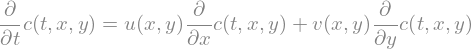

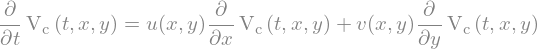

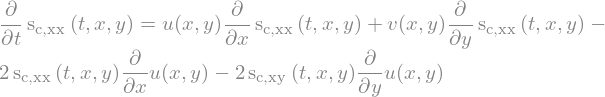

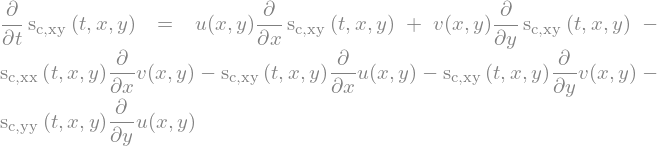

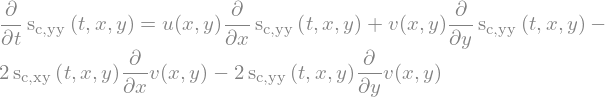

In [19]:
for equation in pkf_advection.in_aspect:    display(equation)

**Conclusion**

We found that the PKF dynamics for advection dynamics is the closed system given by

$$
        \left\{
        \begin{array}{l}
        \partial_t c +\mathbf{u}\nabla c = 0,\\
        \partial_t V_c +\mathbf{u}\nabla V_c = 0,\\
        \partial_t \mathbf{s}_c +\mathbf{u}\nabla\mathbf{s}_c = 
            \left(\nabla\bu\right) \mathbf{s}_c+ \mathbf{s}_c\left(\nabla\mathbf{u}\right)^T.
        \end{array}
        \right .
$$

# Numerical experiment to assess the skill of the closed PKF dynamics

In the numerical example, we consider the dynamics written in aspect tensor form.

## Automatic code generation from the closed PKF system

SymPKF comes with a python numerical code generator which translate a system of partial differential equation into a python's code using `numpy` and where the partial derivative with respect to spatial coordinates are approximated thanks to a finite difference approach, consistent at the second order.

In [20]:
from sympkf import FDModelBuilder

**Automatic code generation for the dynamics**

In [21]:
cas_model = FDModelBuilder(dynamics.equations, class_name="Advection2D")

# uncomments the following line to see the generated code
#print(cas_model.code) 

infile = False
if infile:
    # -1- Write module
    cas_model.write_module()
    # -2- Load module
    exec(f"from {cas_model.module_name} import {cas_model.class_name}")
else:
    exec(cas_model.code)

**Automatic code generation for the PKF dynamics**

In [22]:
cas_model = FDModelBuilder(pkf_advection.in_aspect, class_name="PKFAdvection2D")

# uncomments the following line to see the generated code
#print(cas_model.code) 

infile = False
if infile:
    # -1- Write module
    cas_model.write_module()
    # -2- Load module
    exec(f"from {cas_model.module_name} import {cas_model.class_name}")
else:
    exec(cas_model.code)

## Numerical experiment

In [23]:
model_shape = 2*(241,)
diffusion_model = Advection2D(shape=model_shape)
num_model = PKFAdvection2D(shape=model_shape)
domain = num_model

**Set initial fields**

In [24]:
import numpy as np

In [25]:
dx, dy = num_model.dx

# Set a dirac at the center of the domain.
U = np.zeros(num_model.shape)
center = (num_model.x[0][num_model.shape[0]//2], num_model.x[1][num_model.shape[0]//2])
l_u = 0.1
U = np.exp(-0.5*((num_model.X[0]-center[0])**2 + (num_model.X[1]-center[1])**2)/l_u**2) 

# Set Variance field
V_u = np.zeros(num_model.shape)
V_u[:] = 1. # 1.

# Set metric tensor
lh = 0.02*domain.lengths[0]
lh = 10.*domain.dx[0]  # is validated with closure 1,2 for V = 1. and time scheme Euler, RK4 and CFL: 1/10, 1/6
lh = 0.1
#lh = 10.*domain.dx[0] # is validated with closure 1  for V = 1. and time scheme Euler, RK4 and CFL 1/10, 1/6
nu_u_xx = np.zeros(num_model.shape)
nu_u_xy = np.zeros(num_model.shape)
nu_u_yy = np.zeros(num_model.shape)

    # Cas isotrope
nu_u_xx[:] = lh**2 *0.5
nu_u_yy[:] = lh**2 * 0.5


In [26]:
num_model.shape

In [27]:
X = np.asarray(num_model.X)
k = np.asarray([1,2])
X = np.moveaxis(X,0,2)
print(X.shape)

np.linalg.norm(X@k -k[0]*num_model.X[0]-k[1]*num_model.X[1])

(241, 241, 2)


**Set constants and time step**

In [28]:
import matplotlib.pyplot as plt

In [29]:
time_scale = 1.
#
# Construction du tenseur de diffusion
#

# a) Définition des composantes principales
lx, ly = 20*dx, 10*dy
#lx, ly = 2*dx, 2*dy
u = lx/time_scale
v = ly/time_scale

# b) Construction d'un matrice de rotation
R = lambda theta : np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])

# d) Set veclocity field

num_model.u = np.zeros(num_model.shape)
num_model.v = np.zeros(num_model.shape)

X = np.moveaxis(np.asarray(num_model.X),0,2)
#k = 2*np.pi*np.array([2,3])
k = 2*np.pi*np.array([1,2])

theta = np.pi/3*np.cos(X@k)
#plt.contourf(*num_model.x, theta)

for i in range(num_model.shape[0]):
    for j in range(num_model.shape[1]):
        lR = R(theta[i,j])
        velocity = lR@np.array([u,v])
        num_model.u[i,j] = velocity[0]
        num_model.v[i,j] = velocity[1]
    
#
# Calcul du pas de temps adapté au problème
#
dt = np.min([dx/u, dy/v])

CFL = 1/6
#CFL = 1/10
num_model._dt = CFL * dt
print('time step:', num_model._dt)

time step: 0.008333333333333333


**Illustrates trend at initial condition**

In [30]:
def plot(field):
    plt.contourf(*num_model.x, field.T)

Text(0.5, 1.0, 'Trend for the diffusion')

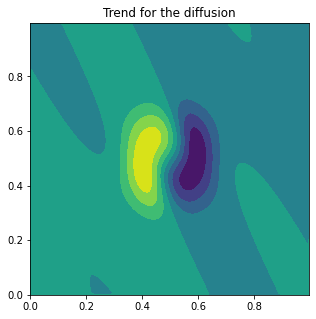

In [31]:
state0 = np.array([U.copy(), V_u.copy(), nu_u_xx.copy(), nu_u_xy.copy(), nu_u_yy.copy()])

trend = num_model.trend(0,state0)
plt.figure(figsize=2*(5,))
plot(trend[0])
plt.title('Trend for the diffusion')

**Short forecast**

In [32]:
times = num_model.window(time_scale)
saved_times = times[::10]
#saved_times = times

In [33]:
num_model.set_time_scheme('rk4')
pkf_traj = num_model.forecast(times, state0, saved_times)

**Diagnosis of u**

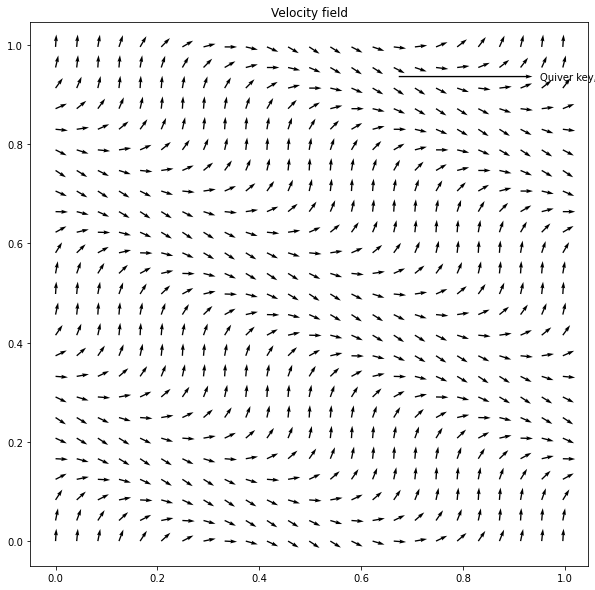

In [34]:
fig, ax = plt.subplots(figsize=(10,10))
pas = 10
q = ax.quiver(num_model.X[0][::pas,::pas],num_model.X[1][::pas,::pas],
              num_model.u[::pas,::pas], num_model.v[::pas,::pas])
ax.quiverkey(q, 0.9,0.9,1,
             label='Quiver key, length = 10', labelpos='E')
plt.title('Velocity field')

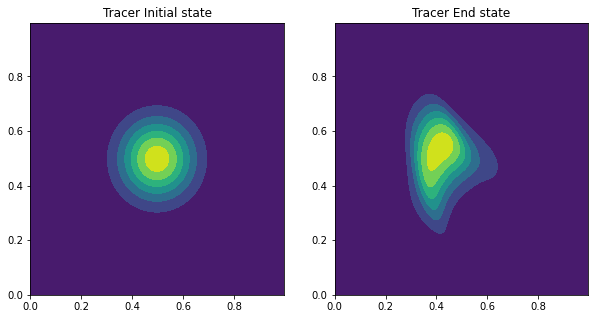

In [35]:
plt.figure(figsize=(10,5))

start, end = [pkf_traj[time] for time in [saved_times[0], saved_times[-1]]]

title = ['Initial state', 'End state']
for k, state in enumerate([start, end]):
    plt.subplot(121+k)
    tmp_state = state[0]    
    plot(tmp_state)
    plt.title('Tracer '+title[k])
    
plt.savefig("./figures/advection-2D-tracer.pdf")    

In [36]:
state[0].min(), state[0].max()

In [37]:
start[0].sum()*dx*dy, end[0].sum()*dx*dy

**Diagnosis of the variance $V_u$**

Text(0.5, 1.0, 'Cross section of the variance at the end time')

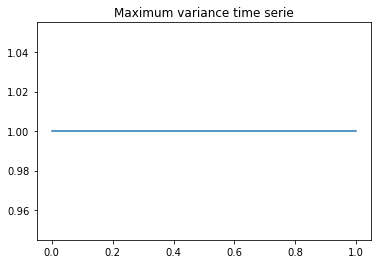

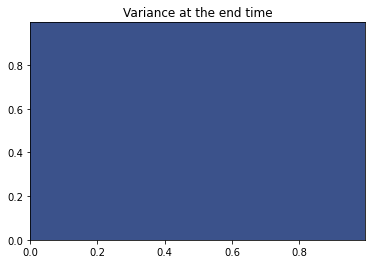

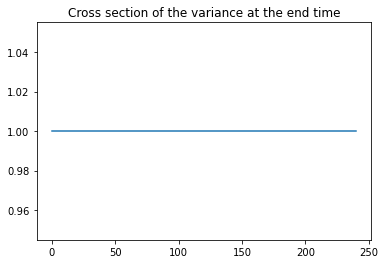

In [38]:
max_V_u = [pkf_traj[time][1].max() for time in saved_times]
plt.plot(saved_times, max_V_u)
plt.title('Maximum variance time serie')
plt.figure()
plot(pkf_traj[saved_times[-1]][1])
plt.title('Variance at the end time')
plt.figure()
plt.plot(pkf_traj[saved_times[-1]][1][0,:])
plt.title('Cross section of the variance at the end time')

**Diagnosis of the metric $g_u$**

In [39]:
from pydap.geometry import MetricTensorField, DiffusionTensorField

In [40]:
domain.dimension = 2

In [41]:
nu_start = MetricTensorField(pkf_traj[saved_times[0]][2:], domain)
nu_end = MetricTensorField(pkf_traj[saved_times[-1]][2:], domain)

In [42]:
radius = 0.1

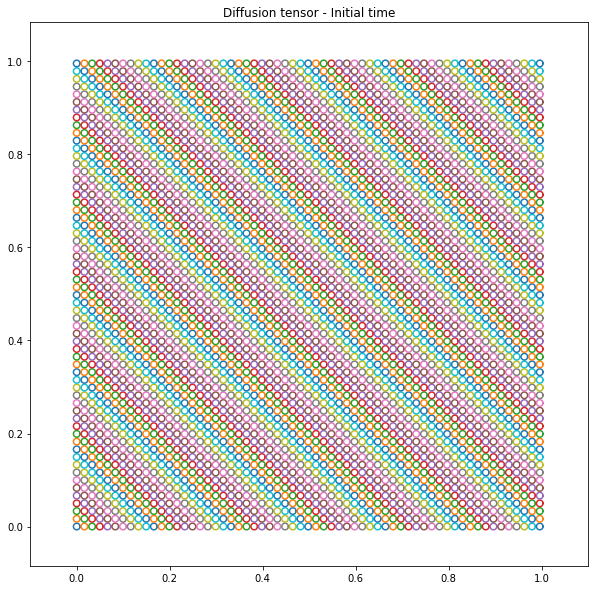

In [43]:
plt.figure(figsize=2*(10,))
nu_start.plot(radius=radius,pas=4)
plt.title('Diffusion tensor - Initial time')
plt.savefig("./figures/advection-2D-diffusion-start.pdf")

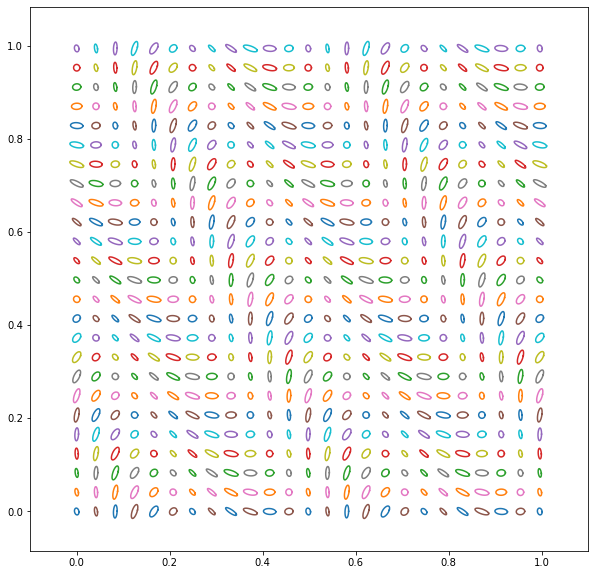

In [44]:
plt.figure(figsize=2*(10,))
pas = 10
#pas = 2
nu_end.plot(radius=radius,pas=pas)

## Ensemble validation of the PKF statistics

**Homogeneous covariance model**

In [45]:
lh/num_model.dx[0]

In [46]:
correlation = np.exp(-1/(2*lh**2)*(
    (domain.X[0]-domain.x[0][domain.shape[0]//2])**2 + (domain.X[1]-domain.x[1][domain.shape[1]//2])**2 
))

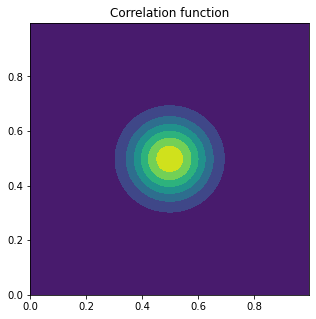

In [47]:
plt.figure(figsize=2*(5,))
plot(correlation)
plt.title('Correlation function');

In [48]:
# Generate intial Gaussian error with the specified correlation function
correlation_spectrum = np.fft.fft2(correlation)
variance_spectrum = np.abs(correlation_spectrum)
std_spectrum = np.sqrt(variance_spectrum)

Ne = 400
ef = [np.real(np.sqrt(V_u[0,0])*np.fft.ifft2(std_spectrum*np.fft.fft2(np.random.normal(size=domain.shape)))) for k in range(Ne)]

### **Ensemble forecast**

In [49]:
# Generate an ensemble of forecast
# 1. Set the diffusion using the same parameters as num_model
diffusion_model.u = num_model.u
diffusion_model.v = num_model.v

# 2. Set the time scheme
diffusion_model.set_time_scheme('rk4')
# 3. Compute the ensemble
start_time, end_time = times[0], times[-1]
ensemble_forecast = diffusion_model.ensemble_forecast(times, [(U+eps).reshape((1,)+domain.shape) for eps in ef], parallel=True, saved_times=[start_time, end_time])

### **Diagnosis of ensemble of forecast**

In [50]:
from pydap.assim.ens import EnsembleState
from pydap.geometry import FlatTorus
torus = FlatTorus(shape=model_shape, dimension=2)

In [51]:
start_ensemble = EnsembleState([elm[0] for elm in ensemble_forecast[start_time]], torus)
end_ensemble = EnsembleState([elm[0] for elm in ensemble_forecast[end_time]], torus)

**Variance field**

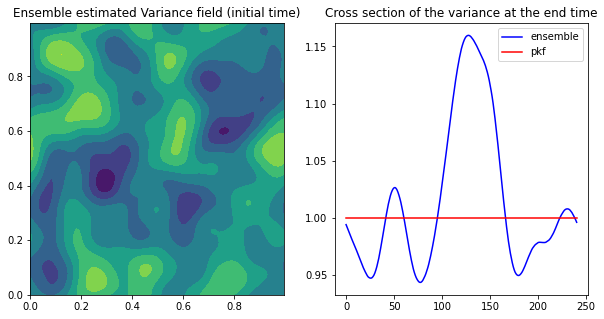

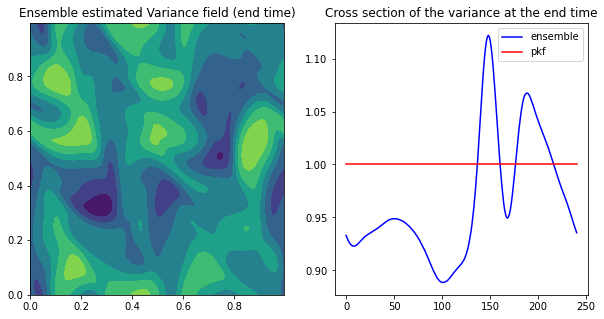

In [52]:
plt.figure(figsize=(10,5))

plt.subplot(121)
plot(start_ensemble['variance'])
plt.title('Ensemble estimated Variance field (initial time)')
plt.subplot(122)
plt.plot(start_ensemble['variance'][0,:],'-b',label='ensemble')
plt.plot(pkf_traj[saved_times[0]][1][0,:],'-r',label='pkf')
plt.legend()
plt.title('Cross section of the variance at the end time')


plt.figure(figsize=(10,5))

plt.subplot(121)
plot(end_ensemble['variance'])
plt.title('Ensemble estimated Variance field (end time)')
plt.subplot(122)
plt.plot(end_ensemble['variance'][0,:],'-b',label='ensemble')
plt.plot(pkf_traj[saved_times[-1]][1][0,:],'-r',label='pkf')
plt.legend()
plt.title('Cross section of the variance at the end time')

**Intermediate result**

While the variance field should be conserved equal to 1, it appears to be heterogeneous. This is an effect of the model error due to the discretization scheme.


**Diffusion tensor field**

In [343]:
if 0:
    # Initial diffusion tensor field estimated from the ensemble
    plt.figure(figsize=2*(5,))
    start_ensemble['diffusion'].plot(radius=radius,pas=4)

In [344]:
if 0:
    # Initial diffusion tensor field estimated from the ensemble
    plt.figure(figsize=2*(10,))
    end_ensemble['diffusion'].plot(radius=radius,pas=4)

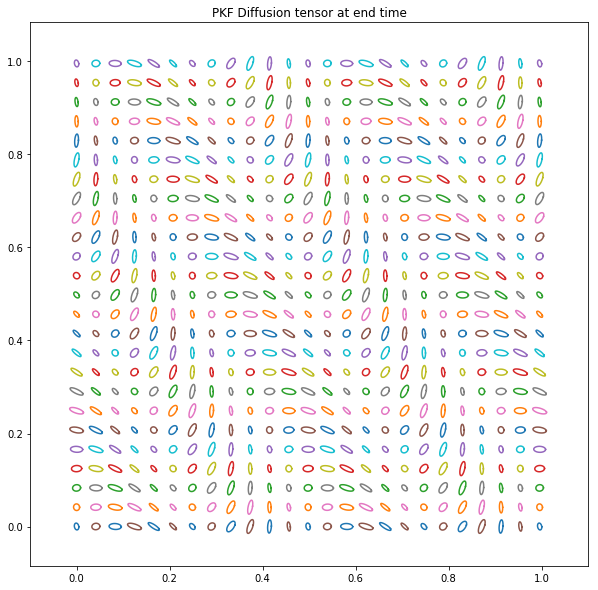

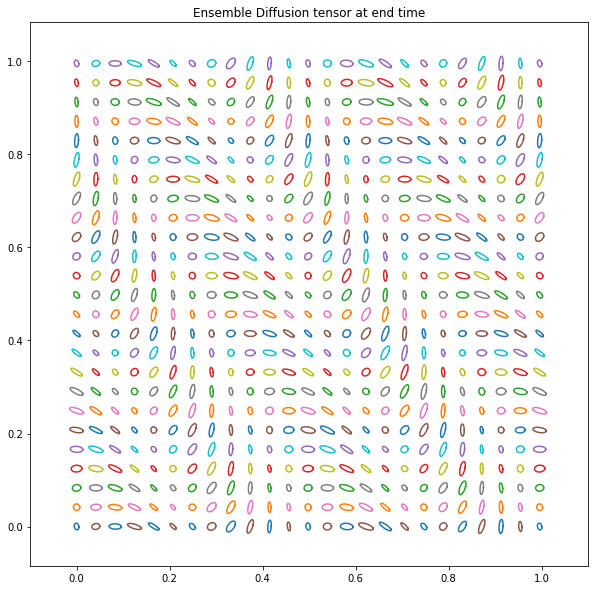

In [345]:
plt.figure(figsize=(10,10))

nu_end.plot(radius=radius,pas=10)
plt.title('PKF Diffusion tensor at end time')

plt.figure(figsize=(10,10))
end_ensemble['diffusion'].plot(radius=radius,pas=10)
plt.title('Ensemble Diffusion tensor at end time')

## Conclusion <a id='conclusion'/>

The PKF dynamics for the linear advection reads as 
$$
        \left\{
        \begin{array}{l}
        \partial_t c +\mathbf{u}\nabla c = 0,\\
        \partial_t V_c +\mathbf{u}\nabla V_c = 0,\\
        \partial_t \mathbf{s}_c +\mathbf{u}\nabla\mathbf{s}_c = 
            \left(\nabla\bu\right) \mathbf{s}_c+ \mathbf{s}_c\left(\nabla\mathbf{u}\right)^T.
        \end{array}
        \right .
$$
Which also reads as 
$$
\left\{
\begin{array}{l}
\displaystyle \frac{\partial}{\partial t} c{\left(t,x,y \right)} = - u{\left(x,y \right)} \frac{\partial}{\partial x} c{\left(t,x,y \right)} - v{\left(x,y \right)} \frac{\partial}{\partial y} c{\left(t,x,y \right)},\\
\displaystyle \frac{\partial}{\partial t} \operatorname{{V_{c}}}{\left(t,x,y \right)} = - u{\left(x,y \right)} \frac{\partial}{\partial x} \operatorname{{V_{c}}}{\left(t,x,y \right)} - v{\left(x,y \right)} \frac{\partial}{\partial y} \operatorname{{V_{c}}}{\left(t,x,y \right)},\\
\displaystyle \frac{\partial}{\partial t} \operatorname{{s_{c,xx}}}{\left(t,x,y \right)} = - u{\left(x,y \right)} \frac{\partial}{\partial x} \operatorname{{s_{c,xx}}}{\left(t,x,y \right)} - v{\left(x,y \right)} \frac{\partial}{\partial y} \operatorname{{s_{c,xx}}}{\left(t,x,y \right)} + 2 \operatorname{{s_{c,xx}}}{\left(t,x,y \right)} \frac{\partial}{\partial x} u{\left(x,y \right)} + 2 \operatorname{{s_{c,xy}}}{\left(t,x,y \right)} \frac{\partial}{\partial y} u{\left(x,y \right)}\\
\displaystyle \frac{\partial}{\partial t} \operatorname{{s_{c,xy}}}{\left(t,x,y \right)} = - u{\left(x,y \right)} \frac{\partial}{\partial x} \operatorname{{s_{c,xy}}}{\left(t,x,y \right)} - v{\left(x,y \right)} \frac{\partial}{\partial y} \operatorname{{s_{c,xy}}}{\left(t,x,y \right)} + \operatorname{{s_{c,xx}}}{\left(t,x,y \right)} \frac{\partial}{\partial x} v{\left(x,y \right)} + \operatorname{{s_{c,xy}}}{\left(t,x,y \right)} \frac{\partial}{\partial x} u{\left(x,y \right)} + \operatorname{{s_{c,xy}}}{\left(t,x,y \right)} \frac{\partial}{\partial y} v{\left(x,y \right)} + \operatorname{{s_{c,yy}}}{\left(t,x,y \right)} \frac{\partial}{\partial y} u{\left(x,y \right)},\\
\displaystyle \frac{\partial}{\partial t} \operatorname{{s_{c,yy}}}{\left(t,x,y \right)} = - u{\left(x,y \right)} \frac{\partial}{\partial x} \operatorname{{s_{c,yy}}}{\left(t,x,y \right)} - v{\left(x,y \right)} \frac{\partial}{\partial y} \operatorname{{s_{c,yy}}}{\left(t,x,y \right)} + 2 \operatorname{{s_{c,xy}}}{\left(t,x,y \right)} \frac{\partial}{\partial x} v{\left(x,y \right)} + 2 \operatorname{{s_{c,yy}}}{\left(t,x,y \right)} \frac{\partial}{\partial y} v{\left(x,y \right)}.
\end{array}
\right. 
$$   